# MACKEY GLASS FORECAST with LSTM, GRU, SimpleRNN

### Load Packages and Data

In [1]:
# from google.colab import files

In [2]:
# files.upload()

In [3]:
def plot_( preds, Y_d):
  plt.figure(figsize=(22,3))
  plt.plot(preds[:,0])
  plt.plot(Y_d)

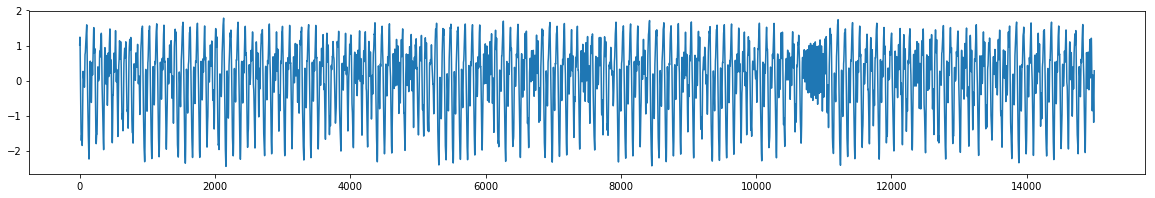

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

import sys
sys.path.append('../Code/pyESN-master/')
data_dir = '../../Data/../Data/Synthetic/Mackey_Glass/'

%matplotlib inline

static_sys_fname = 'mackey_glass_simple_with_random_shocks_'
dynamic_sys_fnam = 'mackey_glass_dynamic_with_random_shocks_'


def load_system(sys_type, shock_scale=None):
  if sys_type not in ['static', 'dynamic']: raise ValueError('Choose a system type')
  if shock_scale is None:
    if sys_type == 'static':
      return np.load(data_dir+'/Static/mackey_glass_simple_no_noise.npy')
    elif sys_type == 'dynamic':
      return np.load(data_dir+'/Dynamic/mackey_glass_dynamic_betabif_without_shocks.npy')

  else:
    if sys_type == 'static':
      return np.load(data_dir+'/Static/mackey_glass_simple_with_random_shocks_'+str(shock_scale)+'.npy')
    elif sys_type == 'dynamic':
      return np.load(data_dir+'/Dynamic/mackey_glass_dynamic_with_random_shocks_'+str(shock_scale)+'.npy')

def normalize(data, trainlen):
  ave = data[:trainlen].mean()
  std = data[:trainlen].std()
  data = data-ave
  data = data/std
  return data

def make_input_output_signals(data, add_bias=True, noise_scale=None):
  input_signal = np.zeros(shape=(len(data)-1,2 if add_bias else 1))
  input_signal[:,0] = data[:-1]
  # input_signal+= np.random.random(data[:-1].shape)*noise_scale
  input_signal[:,1] = 1

  target_signal = data[1:]
  return input_signal ,target_signal





trainlen = 10000
vallen = 2500
testlen = 2500

data = normalize(load_system('static', None), trainlen)
plt.figure(figsize=(20,3))
plt.plot(data)

In [8]:
def plot_system(pred_training, pred_val, skip_from_train=0.9, train_pred_plot=None, window_len=0):



  if (train_pred_plot is None) or (train_pred_plot > 1 - skip_from_train):
    train_pred_plot = int( (1 - skip_from_train)*len(pred_training) )
  skip_from_train = int(skip_from_train*len(pred_training))
  

  

  fig = plt.figure(figsize=(25,4))
  plt.plot(range(skip_from_train,trainlen+vallen),target_signal[skip_from_train:trainlen+vallen],'k',label="target system")

  plt.plot(range(trainlen-train_pred_plot,trainlen+vallen-window_len),np.concatenate([pred_training[-train_pred_plot:],pred_val]),'r', label="free running ESN")

  lo,hi = plt.ylim()
  plt.plot([trainlen-2,trainlen-2],[lo+np.spacing(1),hi-np.spacing(1)],'k:', lw=1)
  plt.legend(loc=(0.61,1.1),fontsize='x-small')
  plt.xlim(skip_from_train, trainlen+vallen)

  return fig


In [9]:
input_signal, target_signal = make_input_output_signals(data)

input_signals = {}
target_signals = {}
input_signals['tr'] =    input_signal[:trainlen]
input_signals['val'] =   input_signal[trainlen:trainlen+vallen]
input_signals['test'] =  input_signal[trainlen+vallen:]
target_signals['tr'] =   target_signal[:trainlen]
target_signals['val'] =  target_signal[trainlen:trainlen+vallen]
target_signals['test']=  target_signal[trainlen+vallen:]



## ONE shot training 
####(whole time series as 3 single samples; 1 for training, 1 for  validation and 1 for test)

### LSTM

In [11]:

model = tf.keras.Sequential()
model.add(layers.Input(shape=(None,1)))
model.add(layers.LSTM(16, return_sequences=True))
model.add(layers.Dense(1))
model.compile(loss='mse', metrics=['mae'], optimizer='Adam')
logger = tf.keras.callbacks.CSVLogger('./Mackey_Glass_LSTM_single_sample.csv', separator=',', append=False)

# model.fit(np.array([input_signal_tr]), np.array([target_signal[:trainlen]]),
#           validation_data=(np.array([input_signal_]), np.array([target_signal[:trainlen]]))



In [12]:
 model.fit(np.array([np.array(input_signals['tr'][:,0]).reshape(input_signals['tr'].shape[0], 1)]), 
           np.array([target_signals['tr']]),  callbacks=[logger],
           validation_data=(np.array([np.array(input_signals['val'][:,0]).reshape(input_signals['val'].shape[0], 1)]), 
                            np.array([target_signals['val']]) )
           ,epochs=70, verbose=True)

Train on 1 samples, validate on 1 samples
Epoch 1/70


KeyboardInterrupt: 

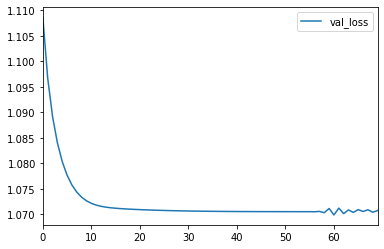

In [0]:
run_logs = pd.read_csv('./Mackey_Glass_LSTM_single_sample.csv')
run_logs[['val_loss']].plot()

1.0007134497264452


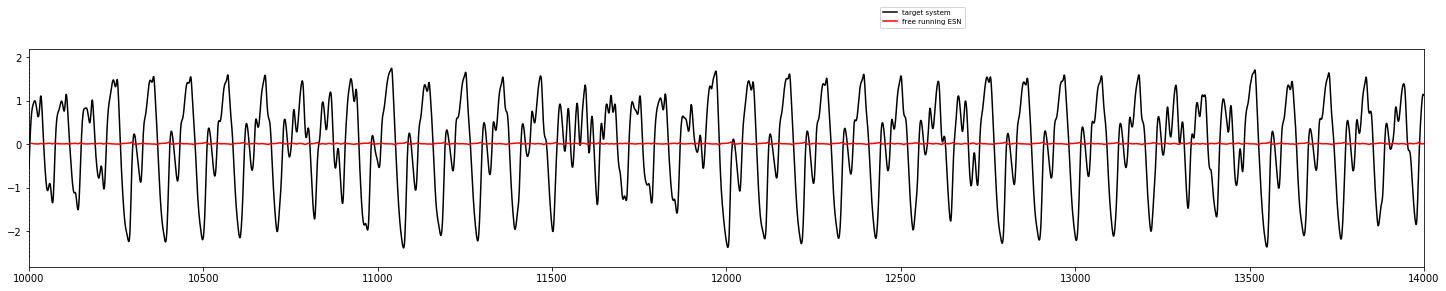

In [0]:
preds_val_lstm = model.predict(x=np.array([np.array(input_signals['val'][:,0]).reshape(input_signals['val'].shape[0], 1)]))
preds_tr_lstm = model.predict(x=np.array([np.array(input_signals['tr'][:,0]).reshape(input_signals['tr'].shape[0], 1)]))
print(np.sqrt( np.mean((preds_val_lstm-target_signals['val'])**2) ) / np.std(target_signals['val']))
fig = lot_system(preds_tr_lstm[0], preds_val_lstm[0], 1).show()
fig.savefig('destination_path.eps', format='eps')

#### GRU

In [0]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(None,1)))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.Dense(1))
model.compile(loss='mse', metrics=['mae'])
logger = tf.keras.callbacks.CSVLogger('./Mackey_Glass_GRU_single_sample.csv', separator=',', append=False)

model.fit(np.array([np.array(input_signals['tr'][:,0]).reshape(input_signals['tr'].shape[0], 1)]), 
           np.array([target_signals['tr']]),  callbacks=[logger],
           validation_data=(np.array([np.array(input_signals['val'][:,0]).reshape(input_signals['val'].shape[0], 1)]), 
                            np.array([target_signals['val']]) )
           ,epochs=70, verbose=True)

1/1 [==============================] - 12s 12s/sample - loss: 0.9750 - mean_absolute_error: 0.8139 - val_loss: 1.0716 - val_mean_absolute_error: 0.8585
Epoch 26/70


KeyboardInterrupt: ignored

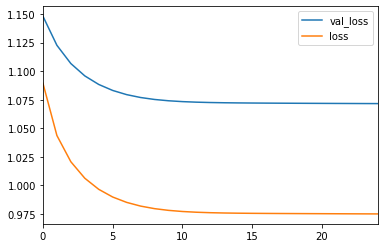

In [0]:
run_logs = pd.read_csv('./Mackey_Glass_GRU_single_sample.csv')
run_logs[['val_loss', 'loss']].plot()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1.0010841503945727


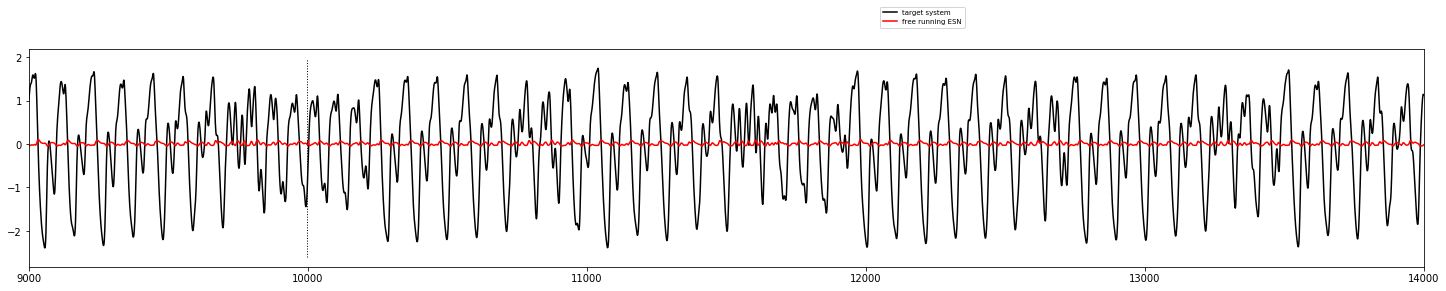

In [0]:
preds_val_rnn = model.predict(x=np.array([np.array(input_signals['val'][:,0]).reshape(input_signals['val'].shape[0], 1)]))
preds_tr_rnn = model.predict(x=np.array([np.array(input_signals['tr'][:,0]).reshape(input_signals['tr'].shape[0], 1)]))
print(np.sqrt( np.mean((preds_val_rnn-target_signals['val'])**2) ) / np.std(target_signals['val']))
plot_system(preds_tr_rnn[0], preds_val_rnn[0], 0.9).savefig('destination_path.eps', format='eps')

In [0]:
files.download('./destination_path.eps')

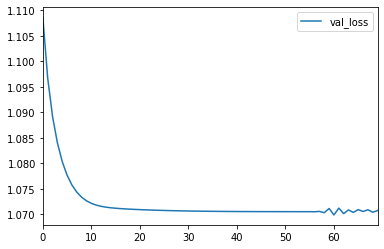

In [0]:
run_logs = pd.read_csv('./Mackey_Glass_LSTM_single_sample.csv')
run_logs[['val_loss']].plot()

1.0007134497264452


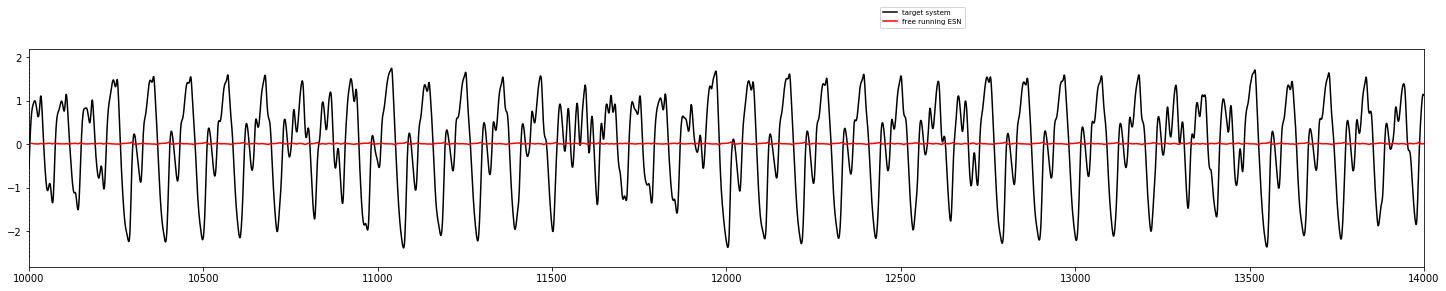

In [0]:
preds_val_lstm = model.predict(x=np.array([np.array(input_signals['val'][:,0]).reshape(input_signals['val'].shape[0], 1)]))
preds_tr_lstm = model.predict(x=np.array([np.array(input_signals['tr'][:,0]).reshape(input_signals['tr'].shape[0], 1)]))
print(np.sqrt( np.mean((preds_val_lstm-target_signals['val'])**2) ) / np.std(target_signals['val']))
plot_system(preds_tr_lstm[0], preds_val_lstm[0], 1).show()

## WINDOW SLIDING TRAINING

### PREDICT NEXT VALUE GIVEN PREVIOUS VALUES

In [13]:

WINDOW_LOOKBACK = 30
FORECAST_HORIZON = 1


X_tr = []
Y_tr = []
X_val = []
Y_val = []
X_te = []
Y_te = []

total_window_size = WINDOW_LOOKBACK+FORECAST_HORIZON

for i in range(0, trainlen-total_window_size):
  X_tr.append(np.array(data[i:i+WINDOW_LOOKBACK]).reshape(WINDOW_LOOKBACK, 1) )
  Y_tr.append(np.array(data[i+WINDOW_LOOKBACK:i+WINDOW_LOOKBACK+1]).reshape(1, ))

for i in range(trainlen, trainlen+vallen-total_window_size):
  X_val.append(np.array(data[i:i+WINDOW_LOOKBACK]).reshape(WINDOW_LOOKBACK, 1) )
  Y_val.append(np.array(data[i+WINDOW_LOOKBACK:i+WINDOW_LOOKBACK+FORECAST_HORIZON]).reshape(1, ))

for i in range(trainlen+vallen, trainlen+vallen+testlen-total_window_size):
  X_te.append(np.array(data[i:i+WINDOW_LOOKBACK]).reshape(WINDOW_LOOKBACK, 1) )
  Y_te.append(np.array(data[i+WINDOW_LOOKBACK:i+WINDOW_LOOKBACK+FORECAST_HORIZON]).reshape(1, ))


#### SimpleRNN

In [16]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(WINDOW_LOOKBACK,1)))
model.add(layers.SimpleRNN(64, return_sequences=True))
model.add(layers.SimpleRNN(32, activation='relu'))

model.add(layers.Dense(1))
model.compile(loss='mse', metrics=['mae'], optimizer='Adam')

log_file_name = './Mackey_Glass_SimpleRNN_W'+str(WINDOW_LOOKBACK)+'.csv'

logger = tf.keras.callbacks.CSVLogger(log_file_name, separator=',', append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./SimpleRNN_best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [17]:
 model.fit(np.array(X_tr),  np.array(Y_tr),
           validation_data=(np.array(X_val), 
                            np.array(Y_val)), 
           callbacks=[logger, checkpoint], 
           epochs=15, 
           verbose=True)

Train on 9969 samples, validate on 2469 samples
Epoch 1/15
9888/9969 [============================>.] - ETA: 0s - loss: 0.0119 - mae: 0.0562
Epoch 00001: val_loss improved from inf to 0.00078, saving model to ./SimpleRNN_best_model.h5
9969/9969 [==============================] - 6s 647us/sample - loss: 0.0118 - mae: 0.0559 - val_loss: 7.8176e-04 - val_mae: 0.0220
Epoch 2/15
9888/9969 [============================>.] - ETA: 0s - loss: 4.8916e-04 - mae: 0.0174
Epoch 00002: val_loss improved from 0.00078 to 0.00043, saving model to ./SimpleRNN_best_model.h5
9969/9969 [==============================] - 6s 564us/sample - loss: 4.8737e-04 - mae: 0.0173 - val_loss: 4.3329e-04 - val_mae: 0.0163
Epoch 3/15
9952/9969 [============================>.] - ETA: 0s - loss: 2.7773e-04 - mae: 0.0130
Epoch 00003: val_loss improved from 0.00043 to 0.00028, saving model to ./SimpleRNN_best_model.h5
9969/9969 [==============================] - 6s 575us/sample - loss: 2.7756e-04 - mae: 0.0130 - val_loss: 2.7

In [27]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(WINDOW_LOOKBACK,1)))
model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.SimpleRNN(64, activation='relu'))

model.add(layers.Dense(1))
model.compile(loss='mse', metrics=['mae'], optimizer='Adam')

log_file_name = './Mackey_Glass_SimpleRNN_big_W'+str(WINDOW_LOOKBACK)+'.csv'


logger = tf.keras.callbacks.CSVLogger(log_file_name, separator=',', append=False)

checkpoint = tf.keras.callbacks.ModelCheckpoint('./SimpleRNN_big_best_model.h5', 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')

In [24]:
 model.fit(np.array(X_tr),  np.array(Y_tr),
           validation_data=(np.array(X_val), 
                            np.array(Y_val)), 
           callbacks=[logger, checkpoint], 
           epochs=15, 
           verbose=True)

Train on 9969 samples, validate on 2469 samples
Epoch 1/15
9888/9969 [============================>.] - ETA: 0s - loss: 0.0079 - mae: 0.0449
Epoch 00001: val_loss improved from inf to 0.00063, saving model to ./SimpleRNN_big_best_model.h5
9969/9969 [==============================] - 8s 780us/sample - loss: 0.0078 - mae: 0.0447 - val_loss: 6.3247e-04 - val_mae: 0.0195
Epoch 2/15
9952/9969 [============================>.] - ETA: 0s - loss: 5.0808e-04 - mae: 0.0177
Epoch 00002: val_loss improved from 0.00063 to 0.00058, saving model to ./SimpleRNN_big_best_model.h5
9969/9969 [==============================] - 7s 700us/sample - loss: 5.0754e-04 - mae: 0.0177 - val_loss: 5.8388e-04 - val_mae: 0.0198
Epoch 3/15
9920/9969 [============================>.] - ETA: 0s - loss: 3.2257e-04 - mae: 0.0141
Epoch 00003: val_loss improved from 0.00058 to 0.00018, saving model to ./SimpleRNN_big_best_model.h5
9969/9969 [==============================] - 8s 792us/sample - loss: 3.2271e-04 - mae: 0.0141 - v

#### LSTM

In [0]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(WINDOW_LOOKBACK,1)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32, activation='relu'))

model.add(layers.Dense(1))
model.compile(loss='mse', metrics=['mae'], optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.))

log_file_name = './Mackey_Glass_LSTM_W'+str(WINDOW_LOOKBACK)+'.csv'

logger = tf.keras.callbacks.CSVLogger(log_file_name, separator=',', append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./LSTM_best_model.h5', 
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True, 
                                                mode='min')

In [152]:
 model.fit(np.array(X_tr),  np.array(Y_tr),
           validation_data=(np.array(X_val), 
                            np.array(Y_val)), 
           callbacks=[logger, checkpoint],  
           epochs=15, 
           verbose=True)

Train on 9969 samples, validate on 2469 samples
Epoch 1/15
9952/9969 [============================>.] - ETA: 0s - loss: 0.3844 - mean_absolute_error: 0.5042
Epoch 00001: val_loss improved from inf to 0.13254, saving model to ./LSTM_best_model.h5
9969/9969 [==============================] - 52s 5ms/sample - loss: 0.3839 - mean_absolute_error: 0.5039 - val_loss: 0.1325 - val_mean_absolute_error: 0.3162
Epoch 2/15
9952/9969 [============================>.] - ETA: 0s - loss: 0.0770 - mean_absolute_error: 0.2351
Epoch 00002: val_loss improved from 0.13254 to 0.08325, saving model to ./LSTM_best_model.h5
9969/9969 [==============================] - 35s 4ms/sample - loss: 0.0771 - mean_absolute_error: 0.2351 - val_loss: 0.0832 - val_mean_absolute_error: 0.2483
Epoch 3/15
9952/9969 [============================>.] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.2070
Epoch 00003: val_loss did not improve from 0.08325
9969/9969 [==============================] - 35s 4ms/sample - loss: 0.0611 -

In [120]:
results = pd.read_csv('./Mackey_Glass_LSTM_W'+str(WINDOW_LOOKBACK)+'.csv', )
results

,epoch,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0,3.404979e-01,4.791868e-01,1.462844e-01,3.353282e-01
1,1,8.619662e-02,2.523749e-01,8.045699e-02,2.395310e-01
2,2,1.088480e+23,4.130752e+10,1.110947e+23,6.075195e+10
3,3,1.818744e+23,7.785257e+10,1.110947e+23,6.075194e+10
4,4,1.818744e+23,7.785260e+10,1.110947e+23,6.075195e+10
5,5,1.818744e+23,7.785257e+10,1.110947e+23,6.075195e+10
6,6,1.818744e+23,7.785257e+10,1.110947e+23,6.075195e+10
7,7,1.818744e+23,7.785261e+10,1.110947e+23,6.075196e+10
8,8,1.818744e+23,7.785257e+10,1.110947e+23,6.075195e+10
9,9,1.818744e+23,7.785263e+10,1.110947e+23,6.075195e+10


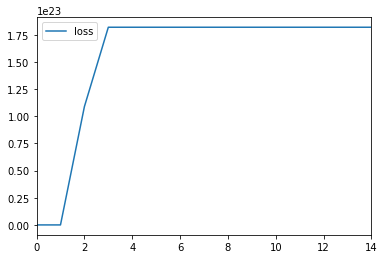

In [121]:
results[['loss']].plot()

In [0]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(WINDOW_LOOKBACK,1)))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(64, activation='relu'))

model.add(layers.Dense(1))
model.compile(loss='mse', metrics=['mae'], optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.))

log_file_name = './Mackey_Glass_LSTM_big_W'+str(WINDOW_LOOKBACK)+'.csv'

logger = tf.keras.callbacks.CSVLogger(log_file_name, separator=',', append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./LSTM_big_best_model.h5', 
                                                monitor='val_loss',
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')

In [0]:
 model.fit(np.array(X_tr),  np.array(Y_tr),
           validation_data=(np.array(X_val), 
                            np.array(Y_val)), 
           callbacks=[logger, checkpoint], 
           epochs=15, 
           verbose=True)

In [124]:
results = pd.read_csv(log_file_name )
results

,epoch,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0,3.263814e-01,4.699925e-01,1.383140e-01,3.261525e-01
1,1,9.139221e-02,2.605650e-01,9.753911e-02,2.614187e-01
2,2,6.432468e-02,2.161133e-01,7.409510e-02,2.256776e-01
3,3,4.938959e-02,1.878352e-01,5.647063e-02,1.967227e-01
4,4,3.740986e-02,1.618025e-01,5.011499e-02,1.827312e-01
5,5,4.708108e+28,5.680452e+12,1.084034e+30,2.541487e+13
6,6,5.698333e+30,6.225262e+13,8.618988e-01,7.581238e-01
7,7,9.990736e-01,8.215742e-01,8.618476e-01,7.580060e-01
8,8,9.991464e-01,8.210219e-01,8.643479e-01,7.625418e-01
9,9,9.991513e-01,8.217298e-01,8.637451e-01,7.616031e-01


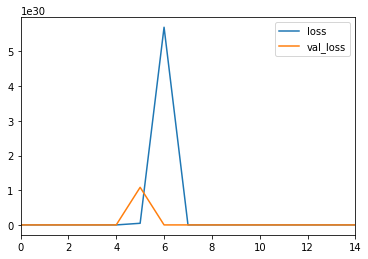

In [126]:
results[['loss','val_loss']].plot()

In [0]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(WINDOW_LOOKBACK,1)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32, activation='relu'))

model.add(layers.Dense(1))
model.compile(loss='mse', metrics=['rmse', 'mae'])

log_file_name = './Mackey_Glass_LSTM_bigger_W'+str(WINDOW_LOOKBACK)+'.csv'

logger = tf.keras.callbacks.CSVLogger(log_file_name, separator=',', append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./LSTM_bigger_best_model.h5', 
                                                monitor='val_loss',
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')

In [156]:
 model.fit(np.array(X_tr),  np.array(Y_tr),
           validation_data=(np.array(X_val), 
                            np.array(Y_val)), 
           callbacks=[logger, checkpoint], 
           epochs=15, 
           verbose=True)

Train on 9969 samples, validate on 2469 samples
Epoch 1/15
9952/9969 [============================>.] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.1766
Epoch 00001: val_loss improved from inf to 0.00796, saving model to ./LSTM_bigger_best_model.h5
9969/9969 [==============================] - 57s 6ms/sample - loss: 0.0686 - mean_absolute_error: 0.1764 - val_loss: 0.0080 - val_mean_absolute_error: 0.0713
Epoch 2/15
9952/9969 [============================>.] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0577
Epoch 00002: val_loss improved from 0.00796 to 0.00192, saving model to ./LSTM_bigger_best_model.h5
9969/9969 [==============================] - 36s 4ms/sample - loss: 0.0057 - mean_absolute_error: 0.0577 - val_loss: 0.0019 - val_mean_absolute_error: 0.0339
Epoch 3/15
9952/9969 [============================>.] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0419
Epoch 00003: val_loss did not improve from 0.00192
9969/9969 [==============================] - 36s 4ms/sample - 

KeyboardInterrupt: ignored

#### GRU

In [0]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(WINDOW_LOOKBACK,1)))
model.add(layers.GRU(128, return_sequences=True))
model.add(layers.GRU(64, activation='relu'))

model.add(layers.Dense(1))
model.compile(loss='mse', metrics=['mae'])

log_file_name = './Mackey_Glass_GRU_W'+str(WINDOW_LOOKBACK)+'.csv'

logger = tf.keras.callbacks.CSVLogger(log_file_name, separator=',', append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./GRU_best_model.h5', 
                                                monitor='val_loss',
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')

In [161]:
 model.fit(np.array(X_tr),  np.array(Y_tr),
           validation_data=(np.array(X_val), 
                            np.array(Y_val)), 
           callbacks=[logger, checkpoint], 
           epochs=15, 
           verbose=True)

Train on 9969 samples, validate on 2469 samples
Epoch 1/15
9952/9969 [============================>.] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.0950
Epoch 00001: val_loss improved from inf to 0.00405, saving model to ./GRU_best_model.h5
9969/9969 [==============================] - 53s 5ms/sample - loss: 0.0286 - mean_absolute_error: 0.0950 - val_loss: 0.0040 - val_mean_absolute_error: 0.0553
Epoch 2/15
9952/9969 [============================>.] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0381
Epoch 00002: val_loss improved from 0.00405 to 0.00065, saving model to ./GRU_best_model.h5
9969/9969 [==============================] - 31s 3ms/sample - loss: 0.0028 - mean_absolute_error: 0.0380 - val_loss: 6.4653e-04 - val_mean_absolute_error: 0.0189
Epoch 3/15
9952/9969 [============================>.] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0297
Epoch 00003: val_loss did not improve from 0.00065
9969/9969 [==============================] - 31s 3ms/sample - loss: 0.0019

In [0]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(WINDOW_LOOKBACK,1)))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(16, activation='relu'))

model.add(layers.Dense(1))
model.compile(loss='mse', metrics=['mae'])

log_file_name = './Mackey_Glass_GRU_big_W'+str(WINDOW_LOOKBACK)+'.csv'

logger = tf.keras.callbacks.CSVLogger(log_file_name, separator=',', append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./GRU_big_best_model.h5', 
                                                monitor='val_loss',
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')

In [0]:
 model.fit(np.array(X_tr),  np.array(Y_tr),
           validation_data=(np.array(X_val), 
                            np.array(Y_val)), 
           callbacks=[logger, checkpoint], 
           epochs=15, 
           verbose=True)

In [0]:
### DOWNLOAD best models

for model_filename in ['./SimpleRNN_best_model.h5',
                       './SimpleRNN_big_best_model.h5',
                       './LSTM_best_model.h5',
                       './LSTM_big_best_model.h5',
                       './GRU_best_model.h5',
                       './GRU_big_best_model.h5']:

                       files.download(model_filename)

### EVALUATION

In [0]:
files.upload([''+ x for x in ['./SimpleRNN_best_model.h5',
                       './SimpleRNN_big_best_model.h5',
                       './LSTM_best_model.h5',
                       './LSTM_big_best_model.h5',
                       './GRU_best_model.h5',
                       './GRU_big_best_model.h5']])

Saving GRU_big_best_model.h5 to GRU_big_best_model.h5
Saving GRU_best_model.h5 to GRU_best_model.h5
Saving LSTM_big_best_model.h5 to LSTM_big_best_model.h5
Saving LSTM_best_model.h5 to LSTM_best_model.h5
Saving SimpleRNN_big_best_model.h5 to SimpleRNN_big_best_model.h5
Saving SimpleRNN_best_model.h5 to SimpleRNN_best_model.h5


{'GRU_best_model.h5': b'\x89HDF\r\n\x1a\n\x00\x00\x00\x00\x00\x08\x08\x00\x04\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff(\xb2\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x88\x00\x00\x00\x00\x00\x00\x00\xa8\x02\x00\x00\x00\x00\x00\x00\x01\x00\x07\x00\x01\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x10\x00\x10\x00\x00\x00\x00\x00 \x03\x00\x00\x00\x00\x00\x00h\x01\x00\x00\x00\x00\x00\x00TREE\x00\x00\x01\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [28]:
models= {}

for  model_filename in ['./SimpleRNN_best_model.h5',
                       './SimpleRNN_big_best_model.h5',
#                        './LSTM_best_model.h5',
#                        './LSTM_big_best_model.h5',
#                        './GRU_best_model.h5',
#                        './GRU_big_best_model.h5'
                       ]:

                       model_name =  model_filename.split('_')[0]
                       if 'big' in model_filename:
                         model_name += '_big'

                       models[model_name] = load_model(model_filename)



# model.evaluate(x=np.array(X_te), y=np.array(Y_te))

ValueError: You are trying to load a weight file containing 3 layers into a model with 0 layers.

In [ ]:
# # rnn_type = []
# # rmse_vals = []
# # rmse_trs = []

# for model_name, model in models.items():
#   print(model_name)
#   # model.evaluate(x=np.array(X_te), y=np.array(Y_te))
#   plot_(model.predict(np.array(X_te))[200:250], Y_te[200:250])
#   plt.show()

In [26]:
def free_running_prediction(model, first_x, steps=5):
  x = first_x
  predictions = []
  for i in range(steps):
    prediction = model.predict(np.array([x]))[0][0]
    predictions.append(prediction)
    x[:-1, 0] = x[1:,0]
    x[-1,0] = prediction
  return np.array(predictions).reshape(steps,1)

for model_name, model in models.items():
  print(model_name)
  plot_(free_running_prediction(model, X_va[0], steps=400), Y_te[:400])
  plt.show()

In [56]:
x = X_te[0]
# prediction = model.predict(np.array([x]))[0][0]

# x = x[1:]+[prediction]
len(x)

100

In [60]:
x[:-1, 0] = x[1:,0]
x[-1,0] = prediction

(99, 1)

In [45]:
model.predict(np.array([X_te[0]]))[0][0]

0.6634676

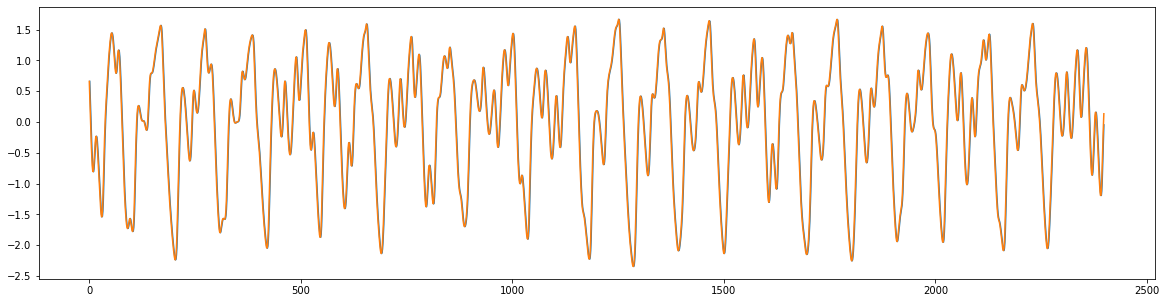

In [0]:
plt.figure(figsize=(20,5))
# plt.plot(range(preds.shape[0]), preds[:,0])
plt.plot(range(1, preds.shape[0]), Y_te[:-1])
plt.plot(range(preds.shape[0]), Y_te)


In [0]:
np.mae()

AttributeError: ignored